In [21]:
## Standard libraries
import os
import math
import numpy as np 
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
# Set Seaborn style
sns.set(style='darkgrid', font_scale=1.2)
from sklearn.datasets import make_moons

## Progress bar
from tqdm.notebook import tqdm

import torch
print("Using torch", torch.__version__)
#torch.manual_seed(42) # Setting the seed
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.distributions.multivariate_normal import MultivariateNormal

from torch.utils.tensorboard import SummaryWriter
import torch.profiler

from GPUtil import showUtilization as gpu_usage

Using torch 1.13.1


In [22]:
class Sampler():
    def __init__(self, p0_sigma, num_z_samples, batch_size, prior_sample_steps, prior_step_size, prior_sigma, posterior_sample_steps, posterior_step_size, posterior_sigma, device):
        
        # Initialize the sampler with the given parameters
        self.p0_sigma = p0_sigma
        self.num_z = num_z_samples
        self.batch_size = batch_size
        self.e_Lsteps = prior_sample_steps
        self.e_step = prior_step_size
        self.e_sigma = prior_sigma
        self.g_Lsteps = posterior_sample_steps
        self.g_step = posterior_step_size
        self.g_sigma = posterior_sigma
        self.device = device
    
    def sample_p0(self):
        
        # Sample from the prior distribution
        return self.p0_sigma * torch.randn(self.batch_size, self.num_z, device=self.device)

    def sample_exp_prior(self, z, EBMmodel):
        
        # Sample from the exponentially-tilted prior distribution
        z = z.clone().detach()
        z.requires_grad = True
        
        for i in range(self.e_Lsteps):
            
            # Compute the gradient of the energy function
            f = EBMmodel(z)
            grad_f = torch.autograd.grad(f.sum(), z)[0]
            
            # Compute the gradient of the log of the prior distribution
            grad_log_f = - 0.5 * self.e_step**2 * (grad_f + 1.0 / (self.e_sigma) * z.data)
            
            # Langevin update
            z.data = z.data + grad_log_f + self.e_step * torch.randn_like(z)
        
        # Compute the norm of the gradient of the energy function
        f_grad_norm = grad_f.view(self.batch_size, -1).norm(dim=1).mean()
        
        return z.detach(), f_grad_norm
    
    def sample_posterior(self, z, x, GENmodel, EBMmodel):
        
        # Sample from the posterior distribution
        z = z.clone().detach()
        z.requires_grad = True
        
        for i in range(self.g_Lsteps):
            
            # Compute the gradient of the log of the likelihood function
            x_pred = GENmodel(z)
            log_g = 1.0 / (2.0 * self.g_sigma**2) * torch.mean((x_pred - x) ** 2)
            grad_g = torch.autograd.grad(log_g, z)[0]

            # Compute the gradient of the energy function
            f = EBMmodel(z)
            grad_f = torch.autograd.grad(f.sum(), z)[0]
            
            # Compute the gradient of the log of the posterior distribution
            grad_log_likelihood = - 0.5 * self.g_step**2 * (grad_g + grad_f + 1.0 / (self.e_sigma**2) * z.data)
            
            # Langevin update
            z.data = z.data + grad_log_likelihood + self.g_step * torch.randn_like(z)

            # Compute the norm of the gradients of the likelihood and energy functions
            g_grad_norm = grad_g.view(self.batch_size, -1).norm(dim=1).mean()
            e_grad_norm = grad_f.view(self.batch_size, -1).norm(dim=1).mean()

        return z.detach(), g_grad_norm, e_grad_norm
            

In [23]:
class priorEBM(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(input_dim, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 128),  
                    nn.ReLU(),
                    nn.Linear(128, output_dim),
                    nn.Tanh()  
                )
            
    def forward(self, z):
        # Returns f_a(z)
        return self.layers(z)
    
class topdownGenerator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
                    nn.Linear(input_dim, 256), 
                    nn.ReLU(),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Linear(128, output_dim),
                    nn.Tanh()  
                )
    
    def forward(self, z):
        # Returns g_b(z)
        return self.layers(z)

In [24]:
def EBM_loss(z_prior, z_posterior, EBMmodel):
            en_neg = torch.mean(EBMmodel(z_prior.detach()), dim=0)
            en_pos = torch.mean(EBMmodel(z_posterior.detach()), dim=0)

            return (en_neg - en_pos).mean()
        
lossE = EBM_loss
lossG = nn.MSELoss(reduction='mean')

  0%|          | 0/5000 [00:00<?, ?it/s]

STAGE:2023-11-10 15:03:10 204348:204348 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
[W CPUAllocator.cpp:231] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2023-11-10 15:03:10 204348:204348 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-11-10 15:03:13 204348:204348 output_json.cpp:417] Completed Stage: Post Processing


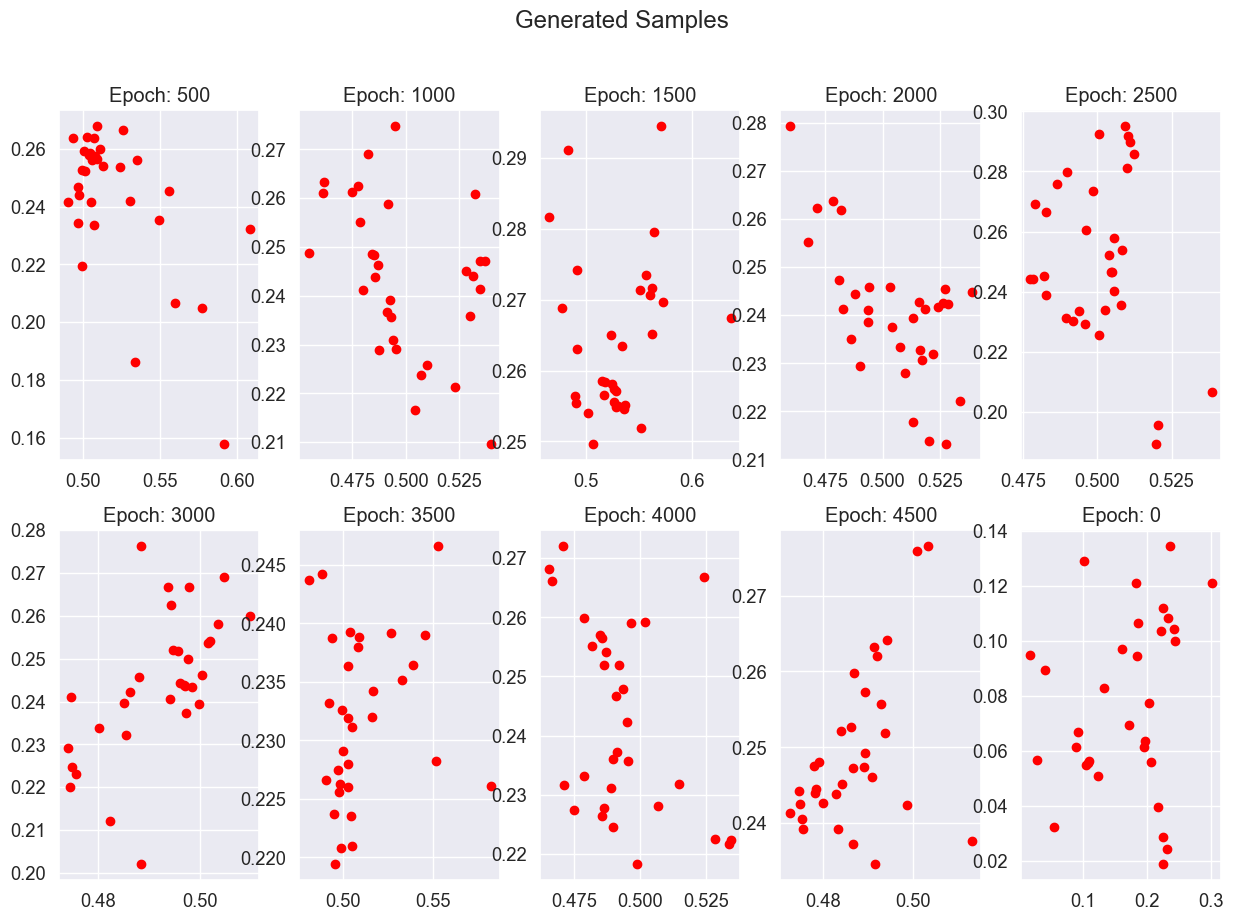

In [25]:
# Hyperparameters
NUM_EPOCHS = 3000
BATCH_SIZE = 128
DATA_SAMPLES = 5000

E_LR = 0.0002
G_LR = 0.001

E_STEP = 0.4
G_STEP = 0.1

E_SAMPLE_STEPS = 20
G_SAMPLE_STEPS = 20

p0_SIGMA = 0.5
EXP_PRIOR_SIGMA = 0.5
GENERATOR_SIGMA = 0.3

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load the moons dataset
X, _ = make_moons(n_samples=DATA_SAMPLES, noise=0.05, random_state=42)
X = torch.tensor(X).float().to(device)
loader = DataLoader(X, batch_size=BATCH_SIZE, shuffle=True)

# Create the model and optimizer
EBMmodel = priorEBM(X.shape[1], X.shape[1]).to(device)
GENmodel= topdownGenerator(X.shape[1], X.shape[1]).to(device)
Sampler = Sampler(
    p0_sigma=p0_SIGMA,
    num_z_samples=X.shape[1],
    batch_size=BATCH_SIZE,
    prior_sample_steps=E_SAMPLE_STEPS,
    prior_step_size=E_STEP,
    prior_sigma=EXP_PRIOR_SIGMA,
    posterior_sample_steps=G_SAMPLE_STEPS,
    posterior_step_size=G_STEP,
    posterior_sigma=GENERATOR_SIGMA,
    device=device
)

EBMoptimiser = torch.optim.Adam(EBMmodel.parameters(), lr=E_LR)
GENoptimiser = torch.optim.Adam(GENmodel.parameters(), lr=G_LR)

# Write to tensorboard 10 times
sample_every = NUM_EPOCHS//10
writer = SummaryWriter(f"runs/VanillaEBM")
num_plots = (NUM_EPOCHS // sample_every) - 1
num_cols = min(5, num_plots)  # Maximum of 2 columns
num_rows = (num_plots - 1) // num_cols + 1

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
fig.suptitle("Generated Samples")

tqdm_bar = tqdm(range(NUM_EPOCHS))

with torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./runs/VanillaEBM/profilerlogs'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
) as prof:
    for epoch in tqdm_bar:
        total_loss = 0
        for batch_idx, x in enumerate(loader): 
            batch_size = x.shape[0]
            
            # 1a. Sample from latent prior
            z0_noise = Sampler.sample_p0() # p0(z)

            # 1b. Expontentially tilt z, sample from posterior
            z_prior, grad_norm = Sampler.sample_exp_prior(z0_noise, EBMmodel) # p(z|M)
            z_posterior, g_grad_norm, e_grad_norm = Sampler.sample_posterior(z_prior, x, GENmodel, EBMmodel) # p(z|x, M)
            
            # 2. Train generator
            GENoptimiser.zero_grad()
            x_pred = GENmodel(z_posterior)
            loss_gen = lossG(x_pred, x)
            loss_gen.backward()
            GENoptimiser.step()
            
            # 3. Train EBM
            EBMoptimiser.zero_grad()
            loss_ebm = lossE(z_prior, z_posterior, EBMmodel)
            loss_ebm.backward()
            EBMoptimiser.step()
            
            total_loss += loss_ebm.item()  + loss_gen.item()
            
            prof.step()
            if batch_idx >= 1 + 1 + 3:
                break

        tqdm_bar.set_description(f"Epoch {epoch}: Loss: {total_loss / (BATCH_SIZE):.4f}")

        if (epoch % sample_every == 0 or epoch == NUM_EPOCHS) and (epoch > 0):
            
            Sampler.batch_size = 1000
            # Need gradients for langevin sampling
            z0_noise = Sampler.sample_p0() # p0(z)
            z_prior, grad_norm = Sampler.sample_exp_prior(z0_noise, EBMmodel) # p(z|M)

            with torch.no_grad():
                x_pred = GENmodel(z_posterior)
                samples = x_pred.detach().cpu()

                plot_num = (epoch // sample_every) - 1
                row = plot_num // num_cols
                col = (plot_num % num_cols)
                axs[row, col].clear()
                axs[row, col].scatter(x=samples[:, 0].numpy(), y=samples[:, 1].numpy(), color='red', marker='o')
                axs[row, col].set_title(f'Epoch: {epoch}')

                # Convert the Matplotlib figure to a NumPy array
                fig.canvas.draw()
                image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
                image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

                # Write the image to TensorBoard
                writer.add_image("VanillaEBM -- Make Moons", image, global_step=epoch, dataformats='HWC')
                Sampler.batch_size = BATCH_SIZE
